# 04 - Red Neuronal Simple: Clasificación de Sentimientos

Este notebook aplica la **red neuronal más simple posible (MLP de 2 capas)** para clasificar el sentimiento de posts en redes sociales.

El modelo se define en `models/simple_nn.py` y se carga desde este notebook.

**Dataset:** SocialBuzz Sentiment Analytics (732 muestras)

**Target:** Sentimiento agrupado en 3 clases: `Positivo`, `Neutro`, `Negativo`

**Arquitectura:** Input -> Linear(64) -> ReLU -> Linear(3) -> CrossEntropy

## 0) Instalación e importación de librerías

In [14]:
import sys
import os

try:
    import kagglehub
except ImportError:
    import subprocess
    subprocess.run(['pip', 'install', 'kagglehub', '-q'])
    import kagglehub

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    #En Colab: montar Drive o clonar el repo de GitHub para acceder a models/simple_nn.py
    #Opción A: clonar el repositorio del proyecto
    #subprocess.run(['git', 'clone', 'https://github.com/TU_USUARIO/TU_REPO.git', '/content/proyecto'])
    #sys.path.insert(0, '/content/proyecto')

    #Opción B: crear el archivo directamente (para que el notebook sea autónomo en Colab)
    os.makedirs('models', exist_ok=True)
    model_code = '''

import torch
import torch.nn as nn

class SimpleSentimentNN(nn.Module):
    """
    Red neuronal simple (MLP) para clasificacion de sentimientos.
    Arquitectura minima: Input -> Linear(hidden) -> ReLU -> Linear(num_classes)
    """
    def __init__(self, input_dim: int, hidden_dim: int = 64, num_classes: int = 3):
        super(SimpleSentimentNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

    def count_parameters(self) -> int:
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

def build_model(input_dim: int, hidden_dim: int = 64, num_classes: int = 3):
    return SimpleSentimentNN(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=num_classes)
'''
    with open('models/simple_nn.py', 'w') as f:
        f.write(model_code)
    #Añadir models/ al path
    sys.path.insert(0, '.')
    print('Archivo models/simple_nn.py creado para Colab.')
else:
    #Localmente: ajustar el path para encontrar el módulo
    current_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else os.getcwd()
    sys.path.insert(0, current_dir)
    print(f'Ejecutando localmente. Path: {current_dir}')

Archivo models/simple_nn.py creado para Colab.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from models.simple_nn import SimpleSentimentNN, build_model
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## 1) Carga de datos

In [16]:
path = kagglehub.dataset_download('eshummalik/socialbuzz-sentiment-analytics')
file_path = os.path.join(path, 'sentimentdataset.csv')
df = pd.read_csv(file_path)

print(f'Shape: {df.shape}')
df.head(3)

Using Colab cache for faster access to the 'socialbuzz-sentiment-analytics' dataset.
Shape: (732, 15)


,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15


## 2) Preprocesado

In [17]:
df['Text'] = df['Text'].astype(str).str.strip()
df['Sentiment'] = df['Sentiment'].astype(str).str.strip()

POSITIVE_EMOTIONS = {
    'Joy', 'Positive', 'Happiness', 'Happy', 'Excitement', 'Elation', 'Euphoria',
    'Love', 'Gratitude', 'Contentment', 'Optimism', 'Hope', 'Hopeful', 'Satisfaction',
    'Pride', 'Proud', 'Amusement', 'Awe', 'Inspiration', 'Inspired', 'Enthusiasm',
    'Confidence', 'Confident', 'Empowerment', 'Freedom', 'Courage', 'Determination',
    'Accomplishment', 'Celebration', 'Serenity', 'Tranquility', 'Peace', 'Calmness',
    'Positivity', 'Blessed', 'Warmth', 'Heartwarming', 'Tenderness', 'Affection',
    'Admiration', 'Adoration', 'Amazement', 'Wonder', 'Wonderment', 'Enchantment',
    'Captivation', 'Marvel', 'Charm', 'Playful', 'PlayfulJoy', 'FestiveJoy',
    'JoyfulReunion', 'Overjoyed', 'Ecstasy', 'Triumph', 'Success', 'Fulfillment',
    'Appreciation', 'Relieved', 'Relief', 'Kindness', 'Kind',
    'Compassion', 'Compassionate', 'Sympathy', 'Empathetic', 'Friendship', 'Romance',
    'Connection', 'Harmony', 'Radiance', 'Zest', 'Energy', 'Vibrancy', 'Spark',
    'Breakthrough', 'Motivation', 'Resilience', 'Adventure', 'Exploration',
    'Curiosity', 'Imagination', 'Creativity', 'Creative Inspiration', 'ArtisticBurst',
    'Grateful', 'Rejuvenation', 'Journey', 'Mindfulness', 'Solace', 'Touched',
    'Acceptance', 'Bittersweet', 'Whimsy', 'Free-spirited',
    'Dazzle', 'Hypnotic', 'Mesmerizing', 'Iconic', 'Melodic', 'Grandeur',
    'Reverence', 'Anticipation', 'Thrill', 'Thrilling Journey', 'Immersion',
    'Engagement', 'Colorful', 'Elegance', 'Runway Creativity',
    'CulinaryOdyssey', 'Culinary Adventure', 'Joy in Baking', 'Adrenaline',
    "Nature's Beauty", "Ocean's Freedom", 'Celestial Wonder', 'Envisioning History',
    'Winter Magic', 'Whispers of the Past', 'Ruins', 'Enjoyment', 'Intrigue',
    'DreamChaser', 'InnerJourney', 'Arousal',
}

NEGATIVE_EMOTIONS = {
    'Negative', 'Sadness', 'Sad', 'Anger', 'Fear', 'Fearful', 'Despair', 'Desperation',
    'Grief', 'Sorrow', 'Heartbreak', 'Heartache', 'LostLove', 'Loss', 'Loneliness',
    'Isolation', 'Disappointment', 'Disappointed', 'Regret', 'Guilt', 'Shame',
    'Frustration', 'Frustrated', 'Hate', 'Resentment', 'Envy', 'Envious',
    'Jealousy', 'Jealous', 'Disgust', 'Betrayal', 'Bitterness', 'Bitter', 'Bad',
    'Desolation', 'Darkness', 'Suffering', 'Helplessness', 'Devastated', 'Overwhelmed',
    'Anxiety', 'Apprehensive', 'Pressure', 'Exhaustion', 'Numbness', 'Melancholy',
    'Pensive', 'Obstacle', 'Miscalculation', 'Intimidation', 'Dismissive',
    'EmotionalStorm', 'Mischievous',
}

NEUTRAL_EMOTIONS = {
    'Neutral', 'Indifference', 'Nostalgia', 'Reflection', 'Contemplation',
    'Ambivalence', 'Surprise', 'Confusion', 'Suspense', 'Yearning', 'Solitude',
    'Coziness', 'Embarrassed', 'Embarrassment',
}

def map_sentiment(sent):
    if sent in POSITIVE_EMOTIONS:
        return 'Positivo'
    elif sent in NEGATIVE_EMOTIONS:
        return 'Negativo'
    elif sent in NEUTRAL_EMOTIONS:
        return 'Neutro'
    else:
        pos_kw = ['joy', 'happy', 'love', 'hope', 'good', 'great', 'excit', 'wonder',
                  'posit', 'glad', 'cheer', 'bright', 'amaz', 'thrill', 'bliss']
        neg_kw = ['sad', 'bad', 'hate', 'fear', 'angry', 'angr', 'grief', 'depress',
                  'negat', 'despair', 'pain', 'sorrow', 'hurt', 'rage', 'bitter']
        s_lower = sent.lower()
        for kw in pos_kw:
            if kw in s_lower:
                return 'Positivo'
        for kw in neg_kw:
            if kw in s_lower:
                return 'Negativo'
        return 'Neutro'

df['sentiment_group'] = df['Sentiment'].apply(map_sentiment)
print('Distribución de clases:')
print(df['sentiment_group'].value_counts())

Distribución de clases:
sentiment_group
Positivo    474
Negativo    175
Neutro       83
Name: count, dtype: int64


In [18]:
le = LabelEncoder()
y = le.fit_transform(df['sentiment_group'])
print(f'Clases: {le.classes_}')

num_features = ['Retweets', 'Likes', 'Year', 'Month', 'Day', 'Hour']
X_num  = df[num_features].fillna(0).values.astype(np.float32)
X_text = df['Text'].values

#División 70/15/15
X_text_train, X_text_temp, X_num_train, X_num_temp, y_train, y_temp = train_test_split(
    X_text, X_num, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_text_val, X_text_test, X_num_val, X_num_test, y_val, y_test = train_test_split(
    X_text_temp, X_num_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

#TF-IDF (solo en train)
MAX_FEATURES = 100  #Reducido para minimizar parámetros del modelo
tfidf = TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=(1, 1), sublinear_tf=True)
X_tfidf_train = tfidf.fit_transform(X_text_train).toarray().astype(np.float32)
X_tfidf_val   = tfidf.transform(X_text_val).toarray().astype(np.float32)
X_tfidf_test  = tfidf.transform(X_text_test).toarray().astype(np.float32)

#Combinamos TF-IDF + numéricas:
X_train_np = np.hstack([X_tfidf_train, X_num_train]) #(N_train, 100+6=106)
X_val_np   = np.hstack([X_tfidf_val,   X_num_val])
X_test_np  = np.hstack([X_tfidf_test,  X_num_test])

INPUT_DIM = X_train_np.shape[1]
NUM_CLASSES = len(le.classes_)
print(f'Train: {len(y_train)} | Val: {len(y_val)} | Test: {len(y_test)}')
print(f'Dimensión de entrada: {INPUT_DIM}  |  Nº clases: {NUM_CLASSES}')

#Calculamos pesos de clase para tratar el desbalanceo:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(weights, dtype=torch.float32).to(device)
print(f'Pesos de clase calculados: {dict(zip(le.classes_, weights))}')

Clases: ['Negativo' 'Neutro' 'Positivo']
Train: 512 | Val: 110 | Test: 110
Dimensión de entrada: 106  |  Nº clases: 3
Pesos de clase calculados: {'Negativo': np.float64(1.3989071038251366), 'Neutro': np.float64(2.942528735632184), 'Positivo': np.float64(0.5140562248995983)}


## 3) Construcción del modelo (desde models/simple_nn.py)

In [19]:
HIDDEN_DIM = 64
model = build_model(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
model = model.to(device)

n_params = model.count_parameters()
print(model)
print(f'\n Número total de parámetros entrenables: {n_params:,}')
print(f'fc1: {INPUT_DIM} x {HIDDEN_DIM} + {HIDDEN_DIM} = {INPUT_DIM*HIDDEN_DIM + HIDDEN_DIM}')
print(f'fc2: {HIDDEN_DIM} x {NUM_CLASSES} + {NUM_CLASSES} = {HIDDEN_DIM*NUM_CLASSES + NUM_CLASSES}')

SimpleSentimentNN(
  (fc1): Linear(in_features=106, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)

 Número total de parámetros entrenables: 7,043
fc1: 106 x 64 + 64 = 6848
fc2: 64 x 3 + 3 = 195


## 4) Entrenamiento

In [20]:
def to_tensors(X, y):
    return TensorDataset(
        torch.tensor(X, dtype=torch.float32),
        torch.tensor(y, dtype=torch.long)
    )

BATCH_SIZE = 32

train_dataset = to_tensors(X_train_np, y_train)
val_dataset   = to_tensors(X_val_np,   y_val)
test_dataset  = to_tensors(X_test_np,  y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE)

print(f'Batches en train: {len(train_loader)}')

Batches en train: 16


In [21]:
EPOCHS = 100
LR     = 1e-3

#Usamos los pesos de clase en la función de pérdida
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LR)

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print(f'Entrenando por {EPOCHS} épocas...\n')
for epoch in range(1, EPOCHS + 1):
    # --- Training ---
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(y_batch)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total += len(y_batch)

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * len(y_batch)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total   += len(y_batch)

    t_loss = train_loss / train_total
    v_loss = val_loss / val_total
    t_acc = train_correct / train_total
    v_acc = val_correct / val_total

    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_acc'].append(t_acc)
    history['val_acc'].append(v_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f'Época {epoch:3d}/{EPOCHS}  |  '
              f'Train Loss: {t_loss:.4f} Train Acc: {t_acc:.4f}  |  '
              f'Val Loss: {v_loss:.4f} Val Acc: {v_acc:.4f}')


Entrenando por 100 épocas...

Época   1/100  |  Train Loss: 40.2890 Train Acc: 0.3906  |  Val Loss: 12.7732 Val Acc: 0.1182
Época  10/100  |  Train Loss: 1.1718 Train Acc: 0.4102  |  Val Loss: 1.1229 Val Acc: 0.6182
Época  20/100  |  Train Loss: 1.1326 Train Acc: 0.4453  |  Val Loss: 1.1653 Val Acc: 0.5545
Época  30/100  |  Train Loss: 1.1914 Train Acc: 0.4199  |  Val Loss: 1.0781 Val Acc: 0.6000
Época  40/100  |  Train Loss: 0.9502 Train Acc: 0.5742  |  Val Loss: 1.1014 Val Acc: 0.3545
Época  50/100  |  Train Loss: 0.9656 Train Acc: 0.5410  |  Val Loss: 1.1371 Val Acc: 0.5182
Época  60/100  |  Train Loss: 1.0336 Train Acc: 0.5020  |  Val Loss: 1.0877 Val Acc: 0.4091
Época  70/100  |  Train Loss: 0.9677 Train Acc: 0.5625  |  Val Loss: 1.5358 Val Acc: 0.6455
Época  80/100  |  Train Loss: 0.8555 Train Acc: 0.6230  |  Val Loss: 1.2407 Val Acc: 0.6909
Época  90/100  |  Train Loss: 0.8653 Train Acc: 0.6641  |  Val Loss: 1.2592 Val Acc: 0.1727
Época 100/100  |  Train Loss: 0.9194 Train Acc: 

## 5) Curvas de entrenamiento

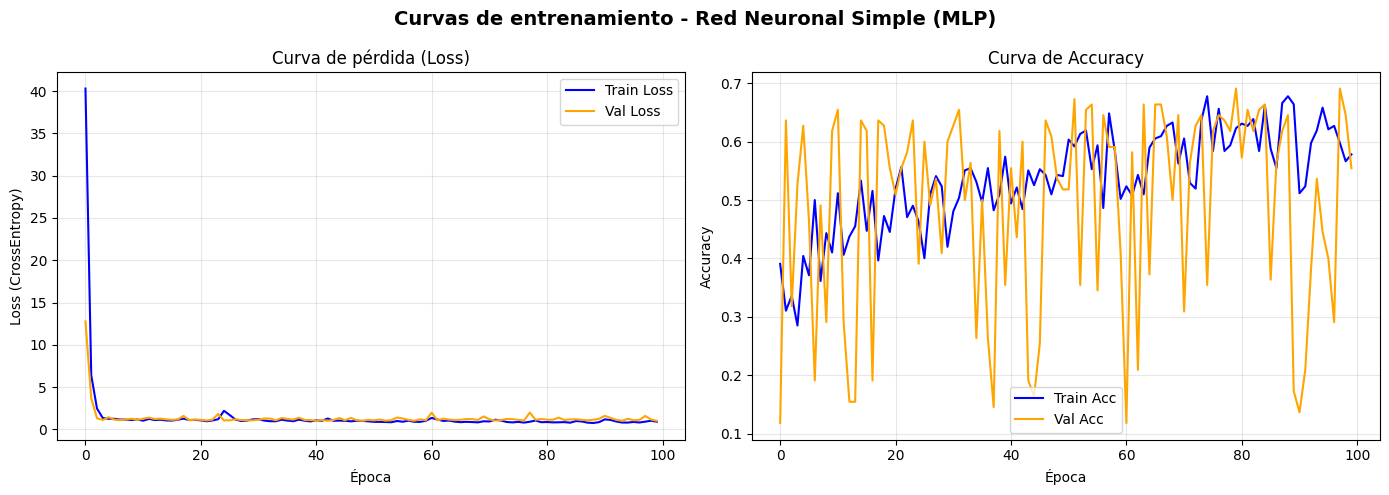


Convergencia final:
 Train Loss: 0.9194 | Val Loss: 1.0155
 Train Acc : 0.5781 | Val Acc : 0.5545


In [23]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Loss:
axes[0].plot(history['train_loss'], label='Train Loss', color='blue')
axes[0].plot(history['val_loss'], label='Val Loss', color='orange')
axes[0].set_title('Curva de pérdida (Loss)')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss (CrossEntropy)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#Accuracy:
axes[1].plot(history['train_acc'], label='Train Acc', color='blue')
axes[1].plot(history['val_acc'],   label='Val Acc',   color='orange')
axes[1].set_title('Curva de Accuracy')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Curvas de entrenamiento - Red Neuronal Simple (MLP)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f'\nConvergencia final:')
print(f' Train Loss: {history["train_loss"][-1]:.4f} | Val Loss: {history["val_loss"][-1]:.4f}')
print(f' Train Acc : {history["train_acc"][-1]:.4f} | Val Acc : {history["val_acc"][-1]:.4f}')

## 6) Evaluación en Train, Validación y Test

In [24]:
def evaluate(model, loader, split_name, class_names, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    prec = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"\n=== {split_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Macro: {f1:.4f}")
    print(f"Precisión: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(classification_report(all_labels, all_preds,
                                target_names=class_names,
                                zero_division=0))

    return acc, f1, prec, rec

class_names = le.classes_

acc_train, f1_train, prec_train, rec_train = evaluate(model, train_loader, 'TRAIN', class_names, device)
acc_val, f1_val, prec_val, rec_val = evaluate(model, val_loader, 'VALIDACIÓN', class_names, device)
acc_test, f1_test, prec_test, rec_test = evaluate(model, test_loader, 'TEST', class_names, device)


=== TRAIN ===
Accuracy: 0.6797
F1-Macro: 0.6444
Precisión: 0.6421
Recall: 0.7594
              precision    recall  f1-score   support

    Negativo       0.61      0.82      0.70       122
      Neutro       0.35      0.86      0.50        58
    Positivo       0.97      0.60      0.74       332

    accuracy                           0.68       512
   macro avg       0.64      0.76      0.64       512
weighted avg       0.81      0.68      0.70       512


=== VALIDACIÓN ===
Accuracy: 0.5545
F1-Macro: 0.4988
Precisión: 0.5262
Recall: 0.5468
              precision    recall  f1-score   support

    Negativo       0.54      0.54      0.54        26
      Neutro       0.19      0.54      0.28        13
    Positivo       0.85      0.56      0.68        71

    accuracy                           0.55       110
   macro avg       0.53      0.55      0.50       110
weighted avg       0.70      0.55      0.60       110


=== TEST ===
Accuracy: 0.5455
F1-Macro: 0.5055
Precisión: 0.5496
Rec

## 7) Matriz de confusión (Test)

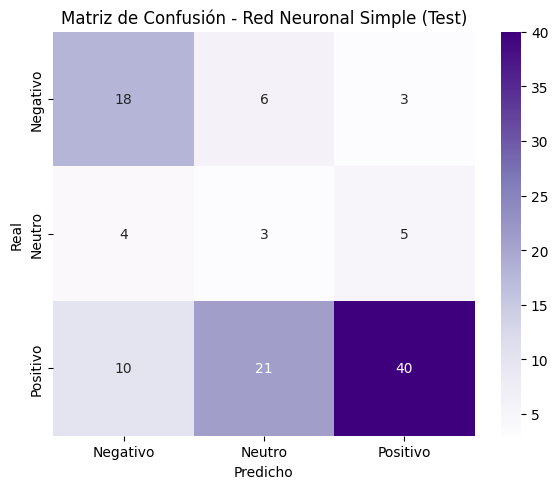

In [25]:
cm = confusion_matrix(y_true_test, y_pred_test_arr)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - Red Neuronal Simple (Test)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.show()

## 8) Resumen de Resultados

In [26]:
results = pd.DataFrame({
    'Split': ['Train', 'Validación', 'Test'],
    'Accuracy': [acc_train, acc_val, acc_test],
    'F1-Macro': [f1_train, f1_val, f1_test],
    'Precision': [prec_train, prec_val, prec_test],
    'Recall': [rec_train, rec_val, rec_test],
})

results = results.round(4)

print("\n=== RESUMEN RED NEURONAL SIMPLE ===")
print(f"Arquitectura: Linear({INPUT_DIM}, {HIDDEN_DIM}) -> ReLU -> Linear({HIDDEN_DIM}, {NUM_CLASSES})")
print(f"Número de parámetros: {n_params:,}")
print(results.to_string(index=False))

print("\nTabla:")
print(f"| Simple MLP | {n_params:,} | "
      f"{acc_train:.4f} | {acc_val:.4f} | {acc_test:.4f} | "
      f"{f1_train:.4f} | {f1_val:.4f} | {f1_test:.4f} | "
      f"{prec_train:.4f} | {prec_val:.4f} | {prec_test:.4f} | "
      f"{rec_train:.4f} | {rec_val:.4f} | {rec_test:.4f} |")


=== RESUMEN RED NEURONAL SIMPLE ===
Arquitectura: Linear(106, 64) -> ReLU -> Linear(64, 3)
Número de parámetros: 7,043
     Split  Accuracy  F1-Macro  Precision  Recall
     Train    0.6797    0.6444     0.6421  0.7594
Validación    0.5545    0.4988     0.5262  0.5468
      Test    0.5455    0.5055     0.5496  0.5579

Tabla:
| Simple MLP | 7,043 | 0.6797 | 0.5545 | 0.5455 | 0.6444 | 0.4988 | 0.5055 | 0.6421 | 0.5262 | 0.5496 | 0.7594 | 0.5468 | 0.5579 |
